In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import random
import lightgbm as lgb
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [2]:
df = pd.read_parquet("fraud_user_time_downsampled.parquet")
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,timestamp,user_is_fraud,UseChipMissing
0,1236,1,1996,4,6,17:28,51.770000,0,-7375635960768263114,Palm Coast,FL,32137.0,5812,0,1996-04-06 17:28:00,1,0
1,1236,1,1996,4,7,16:29,50.869999,0,-6035332392926029059,Palm Coast,FL,32137.0,5812,0,1996-04-07 16:29:00,1,0
2,1236,1,1996,4,7,17:02,60.619999,0,-7375635960768263114,Palm Coast,FL,32137.0,5812,0,1996-04-07 17:02:00,1,0
3,1236,1,1996,4,8,05:45,156.860001,0,-5949357157231676152,ONLINE,Unknown,nan,4900,0,1996-04-08 05:45:00,1,1
4,1236,1,1996,4,8,15:14,18.650000,0,8576350507790891696,Palm Coast,FL,32137.0,5813,0,1996-04-08 15:14:00,1,0


In [3]:
print(df['Is Fraud?'].mean())           # overall fraud rate
print(df['timestamp'].min(), df['timestamp'].max())
print(df.groupby('User')['Amount'].count().describe())

0.02844555761790818
1996-04-06 17:28:00 2019-11-26 02:02:00
count    1343.000000
mean      266.370812
std        98.150214
min        34.000000
25%       200.000000
50%       200.000000
75%       394.000000
max       400.000000
Name: Amount, dtype: float64


In [4]:
# --- Create user-level fraud flag ---
if 'user_is_fraud' in df.columns:
    df = df.drop(columns=['user_is_fraud'])

user_fraud_map = (
    df.groupby('User')['Is Fraud?']
    .max()
    .reset_index()
    .rename(columns={'Is Fraud?': 'user_is_fraud'})
)

df = df.merge(user_fraud_map, on='User', how='left')

# --- Compute each user's first transaction date ---
if 'first_txn_time' in df.columns:
    df = df.drop(columns=['first_txn_time'])

user_first_txn = (
    df.groupby('User')['timestamp']
    .min()
    .reset_index()
    .rename(columns={'timestamp': 'first_txn_time'})
)

df = df.merge(user_first_txn, on='User', how='left')

# --- Sort users by first transaction time ---
user_first_txn = user_first_txn.sort_values('first_txn_time').reset_index(drop=True)

# --- Split users based on time quantiles (no overlap) ---
n_users = len(user_first_txn)
train_users = user_first_txn.iloc[:int(0.7 * n_users)]
val_users   = user_first_txn.iloc[int(0.7 * n_users):int(0.85 * n_users)]
test_users  = user_first_txn.iloc[int(0.85 * n_users):]

# --- Ensure fraud coverage ---
def ensure_fraud_coverage(source_users, target_users, df_source, frac=0.1):
    fraud_users_target = target_users['User'].isin(
        df_source.loc[df_source['user_is_fraud'] == 1, 'User']
    )
    if fraud_users_target.sum() == 0:
        fraud_from_source = (
            df_source[df_source['user_is_fraud'] == 1]
            .sample(frac=frac, random_state=42)[['User']]
        )
        target_users = pd.concat([target_users, fraud_from_source]).drop_duplicates()
    return target_users

val_users  = ensure_fraud_coverage(train_users, val_users, df)
test_users = ensure_fraud_coverage(train_users, test_users, df)

# --- Keep all transactions of selected users ---
train_df = df[df['User'].isin(train_users['User'])]
val_df   = df[df['User'].isin(val_users['User'])]
test_df  = df[df['User'].isin(test_users['User'])]

# --- Verify no overlap ---
assert len(set(train_df['User']).intersection(val_df['User'])) == 0
assert len(set(train_df['User']).intersection(test_df['User'])) == 0
assert len(set(val_df['User']).intersection(test_df['User'])) == 0

# --- Save ---
train_df.to_parquet("split_train.parquet", index=False)
val_df.to_parquet("split_val.parquet", index=False)
test_df.to_parquet("split_test.parquet", index=False)


# --- Summary ---
def show_summary(name, d):
    print(f"\n{name}")
    print("Rows:", len(d))
    print("Users:", d['User'].nunique())
    print("Fraud Txns:", d['Is Fraud?'].sum())
    print("Fraud %:", round(d['Is Fraud?'].mean() * 100, 4))
    print("Period:", d['timestamp'].min(), "→", d['timestamp'].max())

show_summary("Train", train_df)
show_summary("Val", val_df)
show_summary("Test", test_df)



Train
Rows: 266176
Users: 940
Fraud Txns: 7656
Fraud %: 2.8763
Period: 1996-04-06 17:28:00 → 2019-11-25 08:44:00

Val
Rows: 50476
Users: 201
Fraud Txns: 1589
Fraud %: 3.148
Period: 2012-04-28 08:55:00 → 2019-10-05 08:21:00

Test
Rows: 41084
Users: 202
Fraud Txns: 931
Fraud %: 2.2661
Period: 2015-11-29 04:08:00 → 2019-11-26 02:02:00


In [5]:
def show_class_balance(name, df):
    counts = df['Is Fraud?'].value_counts().sort_index()
    total = len(df)
    fraud_ratio = (counts.get(1, 0) / total) * 100
    print(f"\n{name} Set:")
    print(counts)
    print(f"Total: {total}")
    print(f"Fraud Ratio: {fraud_ratio:.4f}%")
    print("-" * 40)

train_df = pd.read_parquet("split_train.parquet")
val_df   = pd.read_parquet("split_val.parquet")
test_df  = pd.read_parquet("split_test.parquet")


show_class_balance("Train", train_df)
show_class_balance("Validation", val_df)
show_class_balance("Test", test_df)



Train Set:
Is Fraud?
0    258520
1      7656
Name: count, dtype: int64
Total: 266176
Fraud Ratio: 2.8763%
----------------------------------------

Validation Set:
Is Fraud?
0    48887
1     1589
Name: count, dtype: int64
Total: 50476
Fraud Ratio: 3.1480%
----------------------------------------

Test Set:
Is Fraud?
0    40153
1      931
Name: count, dtype: int64
Total: 41084
Fraud Ratio: 2.2661%
----------------------------------------


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 266176, number of used features: 8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028763 -> initscore=-3.519483
[LightGBM] [Info] Start training from score -3.519483
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.968175	valid_0's binary_logloss: 0.186245
Early stopping, best iteration is:
[3]	valid_0's auc: 0.946567	valid_0's binary_logloss: 0.113085

Best threshold for F1: 0.204

Confusion Matrix:
 [[39687   

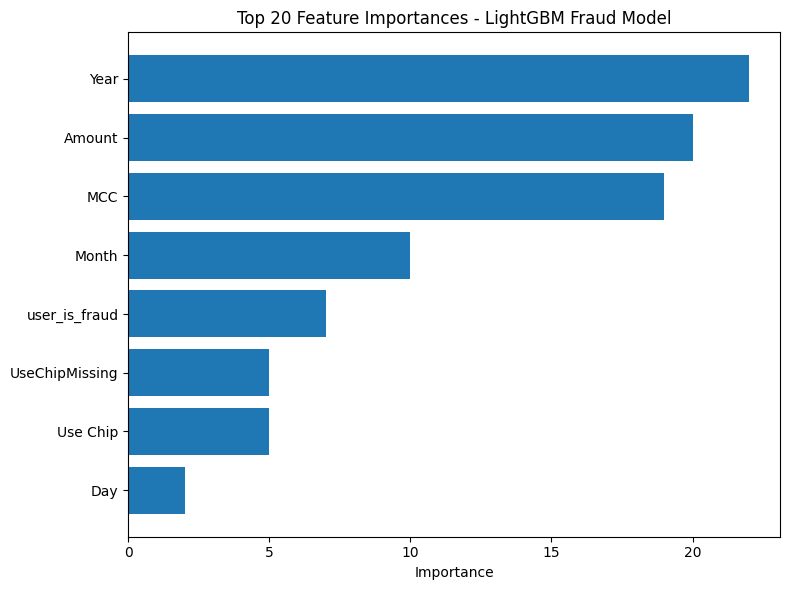


✅ Model saved as lightgbm_final_model.pkl


In [6]:
# --- Load prepared splits from Drive (persistent path) ---
train_df = pd.read_parquet("split_train.parquet")
val_df   = pd.read_parquet("split_val.parquet")
test_df  = pd.read_parquet("split_test.parquet")

# --- Define target and features ---
target = 'Is Fraud?'
drop_cols = [
    'Is Fraud?', 'User', 'Card', 'timestamp',
    'Merchant Name', 'Merchant City', 'Merchant State', 'Zip'
]

# Drop or convert non-numeric columns that LightGBM cannot handle
non_numeric_cols = train_df.select_dtypes(include=['object', 'datetime']).columns.tolist()
drop_cols = list(set(drop_cols + non_numeric_cols))
features = [col for col in train_df.columns if col not in drop_cols]

# --- Prepare splits ---
X_train, y_train = train_df[features], train_df[target]
X_val, y_val     = val_df[features], val_df[target]
X_test, y_test   = test_df[features], test_df[target]

# --- Handle class imbalance ---
pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

# --- Initialize model ---
model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=pos_weight,
    random_state=SEED
)

# --- Train model ---
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=50)
    ]
)

# --- Predict ---
y_pred_proba = model.predict_proba(X_test)[:, 1]

# --- Find best threshold for F1 ---
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = f1.argmax()
best_threshold = thresholds[best_idx]

print(f"\nBest threshold for F1: {best_threshold:.3f}")

y_pred = (y_pred_proba >= best_threshold).astype(int)

# --- Evaluate ---
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4, zero_division=0))

# --- Feature importance plot ---
importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), [features[i] for i in indices][::-1])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances - LightGBM Fraud Model")
plt.tight_layout()
plt.show()

# --- Save trained model to Drive ---
import joblib
joblib.dump(model, "lightgbm_final_model.pkl")
print("\n✅ Model saved as lightgbm_final_model.pkl")


In [7]:
# --- Behavioral / Temporal Feature Engineering (safe version) ---

# Sort by user and time
df = df.sort_values(['User', 'timestamp']).reset_index(drop=True)

# --- Rolling window aggregations ---
windows = [7, 30, 90]

for w in windows:
    df[f'amount_sum_{w}d'] = (
        df.groupby('User')['Amount']
          .transform(lambda x: x.rolling(window=w, min_periods=1).sum())
    )
    df[f'txn_count_{w}d'] = (
        df.groupby('User')['Amount']
          .transform(lambda x: x.rolling(window=w, min_periods=1).count())
    )
    df[f'avg_amt_{w}d'] = df[f'amount_sum_{w}d'] / (df[f'txn_count_{w}d'] + 1e-9)

# --- Spend ratios ---
df['spend_ratio_7_30'] = df['amount_sum_7d'] / (df['amount_sum_30d'] + 1e-9)
df['spend_ratio_30_90'] = df['amount_sum_30d'] / (df['amount_sum_90d'] + 1e-9)

# --- Merchant diversity (unique merchants in last 30 txns) ---
df['merchant_diversity_30'] = (
    df.groupby('User')['Merchant Name']
      .transform(lambda x: x.astype(str).rolling(window=30, min_periods=1)
      .apply(lambda w: len(set(w)), raw=False))
)

# --- Time gap features ---
df['prev_txn_time'] = df.groupby('User')['timestamp'].shift(1)
df['time_diff_hours'] = (df['timestamp'] - df['prev_txn_time']).dt.total_seconds() / 3600
df['avg_gap_7d'] = (
    df.groupby('User')['time_diff_hours']
      .transform(lambda x: x.rolling(window=7, min_periods=1).mean())
)

# --- Clean numeric-only columns safely ---
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)
df[num_cols] = df[num_cols].fillna(0)

# --- Save enhanced dataset ---
df.to_parquet("df_with_behavioral_features.parquet", index=False)

print("✅ Behavioral and temporal features added successfully.")
print("New feature columns:", [c for c in df.columns if any(k in c for k in ['sum_', 'count_', 'avg_', 'ratio', 'diversity', 'gap'])])


✅ Behavioral and temporal features added successfully.
New feature columns: ['amount_sum_7d', 'txn_count_7d', 'avg_amt_7d', 'amount_sum_30d', 'txn_count_30d', 'avg_amt_30d', 'amount_sum_90d', 'txn_count_90d', 'avg_amt_90d', 'spend_ratio_7_30', 'spend_ratio_30_90', 'merchant_diversity_30', 'avg_gap_7d']


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7746, number of negative: 260282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3151
[LightGBM] [Info] Number of data points in the train set: 268028, number of used features: 22
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028900 -> initscore=-3.514589
[LightGBM] [Info] Start training from score -3.514589
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.979588	valid_0's binary_logloss: 0.165666
Early stopping, best iteration is:
[2]	valid_0's auc: 0.950926	valid_0's binary_logloss: 0.111482

Best threshold for F1: 0.153

Confusion Matrix:
 [[39285  1120]
 [  441   500]]

Classification Report:
               pr

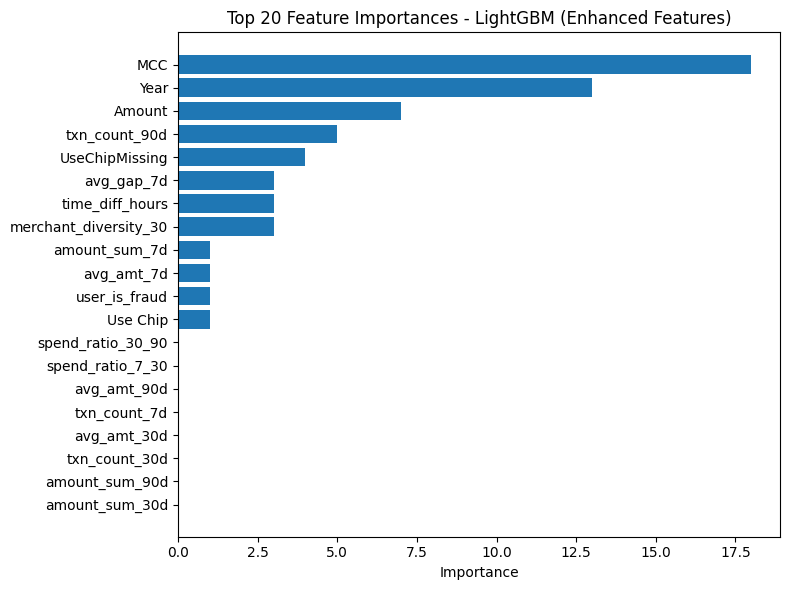

In [8]:
# --- Split same as before (based on your saved user splits) ---
df = pd.read_parquet("df_with_behavioral_features.parquet")
train_df = pd.read_parquet("split_train.parquet")
val_df   = pd.read_parquet("split_val.parquet")
test_df  = pd.read_parquet("split_test.parquet")

# Merge new engineered features with existing splits using (User, timestamp)
merge_cols = ['User', 'timestamp']
train_df = train_df.merge(df[merge_cols + [c for c in df.columns if c not in train_df.columns]],
                          on=merge_cols, how='left')
val_df   = val_df.merge(df[merge_cols + [c for c in df.columns if c not in val_df.columns]],
                        on=merge_cols, how='left')
test_df  = test_df.merge(df[merge_cols + [c for c in df.columns if c not in test_df.columns]],
                         on=merge_cols, how='left')

# --- Target and feature selection ---
target = 'Is Fraud?'
drop_cols = [
    'Is Fraud?', 'User', 'Card', 'timestamp',
    'Merchant Name', 'Merchant City', 'Merchant State', 'Zip',
    'prev_txn_time', 'first_txn_time'
]

# Exclude any object/datetime columns
non_numeric = df.select_dtypes(include=['object', 'datetime']).columns.tolist()
drop_cols = list(set(drop_cols + non_numeric))

features = [col for col in train_df.columns if col not in drop_cols]

X_train, y_train = train_df[features], train_df[target]
X_val, y_val     = val_df[features], val_df[target]
X_test, y_test   = test_df[features], test_df[target]

# --- Model setup with imbalance handling ---
pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=pos_weight,
    random_state=42
)

# --- Train model with early stopping ---
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[early_stopping(50), log_evaluation(50)]
)

# --- Evaluate on test set ---
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Find best threshold (max F1)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = f1.argmax()
best_threshold = thresholds[best_idx]

print(f"\nBest threshold for F1: {best_threshold:.3f}")

y_pred = (y_pred_proba >= best_threshold).astype(int)

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4, zero_division=0))

# --- PR-AUC ---
pr_auc = auc(recall, precision)
print(f"\nPrecision-Recall AUC: {pr_auc:.4f}")

# --- Feature Importance Plot ---
importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), [features[i] for i in indices][::-1])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances - LightGBM (Enhanced Features)")
plt.tight_layout()
plt.show()


In [9]:

# --- Compute precision-recall pairs across thresholds ---
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# --- Convert to DataFrame for inspection ---
pr_df = pd.DataFrame({
    'threshold': thresholds,
    'precision': precision[:-1],
    'recall': recall[:-1],
    'f1': 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9)
})

# --- Sort by F1 to see best overall threshold ---
best_f1_row = pr_df.iloc[pr_df['f1'].idxmax()]
print("\nBest F1 threshold summary:")
print(best_f1_row)

# --- Choose threshold meeting business goals ---
target_precision = 0.35
target_recall = 0.65

# Find thresholds that meet or exceed both targets
valid_thresholds = pr_df[
    (pr_df['precision'] >= target_precision) & (pr_df['recall'] >= target_recall)
]

if not valid_thresholds.empty:
    best_threshold = valid_thresholds.iloc[valid_thresholds['f1'].idxmax()]['threshold']
    print(f"\n✅ Threshold meeting target precision ≥{target_precision} and recall ≥{target_recall}: {best_threshold:.3f}")
else:
    best_threshold = best_f1_row['threshold']
    print(f"\n⚠️ No threshold meets both targets — using best F1 threshold: {best_threshold:.3f}")

# --- Predict using chosen threshold ---
y_pred = (y_pred_proba >= best_threshold).astype(int)

# --- Evaluate results ---
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4, zero_division=0))



Best F1 threshold summary:
threshold    0.153194
precision    0.308642
recall       0.531350
f1           0.390472
Name: 201, dtype: float64

⚠️ No threshold meets both targets — using best F1 threshold: 0.153

Confusion Matrix:
 [[39285  1120]
 [  441   500]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9889    0.9723    0.9805     40405
           1     0.3086    0.5313    0.3905       941

    accuracy                         0.9622     41346
   macro avg     0.6488    0.7518    0.6855     41346
weighted avg     0.9734    0.9622    0.9671     41346



In [12]:
import optuna
import joblib


# --- Load data from Drive (persistent paths) ---
train_df = pd.read_parquet("split_train.parquet")
val_df   = pd.read_parquet("split_val.parquet")

target = 'Is Fraud?'

drop_cols = [
    'Is Fraud?', 'User', 'Card', 'timestamp',
    'Merchant Name', 'Merchant City', 'Merchant State', 'Zip',
    'prev_txn_time', 'first_txn_time'
]
non_numeric = train_df.select_dtypes(include=['object', 'datetime']).columns.tolist()
drop_cols = list(set(drop_cols + non_numeric))
features = [c for c in train_df.columns if c not in drop_cols]

X_train, y_train = train_df[features], train_df[target]
X_val, y_val     = val_df[features], val_df[target]

# --- Handle imbalance ---
pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

# --- Optuna objective ---
def objective(trial):
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 80),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 200),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'scale_pos_weight': pos_weight,
        'random_state': SEED,
        'n_jobs': -1
    }

    model = LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[
            early_stopping(stopping_rounds=50),
            log_evaluation(period=50)
        ]
    )

    y_pred_proba = model.predict_proba(X_val)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    pr_auc = auc(recall, precision)

    return pr_auc

# --- Run Optuna study (reproducible) ---
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED)
)
study.optimize(objective, n_trials=30, show_progress_bar=True)

# --- Show results ---
print("\n✅ Best Parameters:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")
print(f"\nBest PR-AUC on validation: {study.best_value:.4f}")

# --- Train final model using best params ---
best_params = study.best_params
best_params.update({
    'n_estimators': 1000,
    'scale_pos_weight': pos_weight,
    'random_state': SEED
})

final_model = LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

# --- Save model to Drive ---
joblib.dump(final_model, "lightgbm_tuned_model.pkl")
print("\n✅ Tuned LightGBM model saved at: lightgbm_tuned_model.pkl")


C:\Users\Daksh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-12-01 11:34:20,561] A new study created in memory with name: no-name-7bd96d3e-2f41-41fa-b64d-9ab5785798ce
  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 266176, number of used features: 8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028763 -> initscore=-3.519483
[LightGBM] [Info] Start training from score -3.519483
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

Best trial: 0. Best value: 0.45849:   3%|█▌                                             | 1/30 [00:00<00:20,  1.38it/s]

[50]	valid_0's auc: 0.96848	valid_0's binary_logloss: 0.177219
Early stopping, best iteration is:
[1]	valid_0's auc: 0.92367	valid_0's binary_logloss: 0.119181
[I 2025-12-01 11:34:21,305] Trial 0 finished with value: 0.45848987878352404 and parameters: {'learning_rate': 0.03574712922600244, 'num_leaves': 77, 'max_depth': 10, 'min_child_samples': 124, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 0.5808361216819946, 'reg_lambda': 8.661761457749352}. Best is trial 0 with value: 0.45848987878352404.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the tr

Best trial: 1. Best value: 0.493503:   7%|███                                           | 2/30 [00:01<00:15,  1.80it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's auc: 0.948345	valid_0's binary_logloss: 0.29996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	valid_0's auc: 0.900847	valid_0's binary_logloss: 0.126615
[I 2025-12-01 11:34:21,743] Trial 1 finished with value: 0.49350316018301527 and parameters: {'learning_rate': 0.07725378389307355, 'num_leaves': 61, 'max_depth': 3, 'min_child_samples': 195, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 1.8182496720710062, 'reg_lambda': 1.8340450985343382}. Best is trial 1 with value: 0.49350316018301527.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[Light

Best trial: 2. Best value: 0.538596:  10%|████▌                                         | 3/30 [00:01<00:15,  1.77it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's auc: 0.96436	valid_0's binary_logloss: 0.180942
Early stopping, best iteration is:
[5]	valid_0's auc: 0.94744	valid_0's binary_logloss: 0.121674
[I 2025-12-01 11:34:22,323] Trial 2 finished with value: 0.5385958103172238 and parameters: {'learning_rate': 0.028145092716060652, 'num_leaves': 49, 'max_depth': 7, 'min_child_samples': 65, 'subsample': 0.8447411578889518, 'colsample_bytree': 0.6557975442608167, 'reg_alpha': 2.9214464853521815, 'reg_lambda': 3.663618432936917}. Best is trial 2 with value: 0.5385958103172238.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM

Best trial: 2. Best value: 0.538596:  13%|██████▏                                       | 4/30 [00:02<00:13,  1.98it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's auc: 0.954

Best trial: 4. Best value: 0.58268:  17%|███████▊                                       | 5/30 [00:02<00:14,  1.75it/s]

Early stopping, best iteration is:
[10]	valid_0's auc: 0.958422	valid_0's binary_logloss: 0.121019
[I 2025-12-01 11:34:23,418] Trial 4 finished with value: 0.5826800057188699 and parameters: {'learning_rate': 0.012476394272569451, 'num_leaves': 77, 'max_depth': 12, 'min_child_samples': 164, 'subsample': 0.7218455076693483, 'colsample_bytree': 0.6390688456025535, 'reg_alpha': 6.842330265121569, 'reg_lambda': 4.4015249373960135}. Best is trial 4 with value: 0.5826800057188699.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 266176, number of used features: 8
[LightGBM] [Warni

Best trial: 4. Best value: 0.58268:  20%|█████████▍                                     | 6/30 [00:03<00:12,  1.90it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's auc: 0.935772	valid_0's binary_logloss: 0.206469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[5]	valid_0's auc: 0.925452	valid_0's binary_logloss: 0.1275
[I 2025-12-01 11:34:23,863] Trial 5 finished with value: 0.41540804963118394 and parameters: {'learning_rate': 0.015144860262751412, 'num_leaves': 47, 'max_depth': 3, 'min_child_samples': 183, 'subsample': 0.7035119926400067, 'colsample_bytree': 0.8650089137415928, 'reg_alpha': 3.1171107608941098, 'reg_lambda': 5.200680211778108}. Best is trial 4 with value: 0.5826800057188699.
[LightGBM

Best trial: 4. Best value: 0.58268:  23%|██████████▉                                    | 7/30 [00:03<00:11,  1.98it/s]

[50]	valid_0's auc: 0.967466	valid_0's binary_logloss: 0.192386
Early stopping, best iteration is:
[1]	valid_0's auc: 0.93831	valid_0's binary_logloss: 0.110125
[I 2025-12-01 11:34:24,325] Trial 6 finished with value: 0.5652446556589078 and parameters: {'learning_rate': 0.06420330336297862, 'num_leaves': 27, 'max_depth': 12, 'min_child_samples': 158, 'subsample': 0.9757995766256756, 'colsample_bytree': 0.9579309401710595, 'reg_alpha': 5.978999788110851, 'reg_lambda': 9.218742350231167}. Best is trial 4 with value: 0.5826800057188699.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the tra

Best trial: 4. Best value: 0.58268:  27%|████████████▌                                  | 8/30 [00:04<00:09,  2.20it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 8. Best value: 0.589155:  30%|█████████████▊                                | 9/30 [00:04<00:09,  2.33it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's auc: 0.951255	valid_0's binary_logloss: 0.21653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[3]	valid_0's auc: 0.934735	valid_0's binary_logloss: 0.121916
[I 2025-12-01 11:34:25,044] Trial 8 finished with value: 0.5891552263475519 and parameters: {'learning_rate': 0.026000059117302653, 'num_leaves': 50, 'max_depth': 4, 'min_child_samples': 163, 'subsample': 0.6298202574719083, 'colsample_bytree': 0.9947547746402069, 'reg_alpha': 7.722447692966574, 'reg_lambda': 1.9

Best trial: 9. Best value: 0.622153:  33%|███████████████                              | 10/30 [00:05<00:10,  1.93it/s]

[50]	valid_0's auc: 0.966486	valid_0's binary_logloss: 0.131973
Early stopping, best iteration is:
[17]	valid_0's auc: 0.962351	valid_0's binary_logloss: 0.120833
[I 2025-12-01 11:34:25,765] Trial 9 finished with value: 0.6221527523695591 and parameters: {'learning_rate': 0.010189592979395137, 'num_leaves': 68, 'max_depth': 10, 'min_child_samples': 149, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'reg_alpha': 3.5846572854427263, 'reg_lambda': 1.1586905952512971}. Best is trial 9 with value: 0.6221527523695591.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in th

Best trial: 9. Best value: 0.622153:  33%|███████████████                              | 10/30 [00:06<00:10,  1.93it/s]

[250]	valid_0's auc: 0.974794	valid_0's binary_logloss: 0.145374
Early stopping, best iteration is:
[231]	valid_0's auc: 0.97494	valid_0's binary_logloss: 0.147376
[I 2025-12-01 11:34:27,392] Trial 10 finished with value: 0.7907632146907988 and parameters: {'learning_rate': 0.19850629115371687, 'num_leaves': 15, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.9016552640704525, 'colsample_bytree': 0.767711244899284, 'reg_alpha': 9.597707459454199, 'reg_lambda': 0.11114384822711276}. Best is trial 10 with value: 0.7907632146907988.


Best trial: 10. Best value: 0.790763:  37%|████████████████▏                           | 11/30 [00:06<00:16,  1.16it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 266176, number of used features: 8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028763 -> initscore=-3.519483
[LightGBM] [Info] Start training from score -3.519483
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.968945	valid_0's binary_logloss: 0.19049
[100]	valid_0's auc: 0.972187	valid_0's binary_logloss: 0.166794
[150]	valid_0's auc: 0.973156	valid_0's binary_logloss: 0.15855
[200]	valid_0's auc: 0.974216	

Best trial: 10. Best value: 0.790763:  40%|█████████████████▌                          | 12/30 [00:07<00:17,  1.04it/s]

[I 2025-12-01 11:34:28,578] Trial 11 finished with value: 0.7777231743887469 and parameters: {'learning_rate': 0.2504825725650327, 'num_leaves': 15, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.9123149587522621, 'colsample_bytree': 0.7737425087025644, 'reg_alpha': 9.580055402844472, 'reg_lambda': 0.10882096071884}. Best is trial 10 with value: 0.7907632146907988.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 266176, number of used features: 8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore

Best trial: 10. Best value: 0.790763:  43%|███████████████████                         | 13/30 [00:09<00:18,  1.11s/it]

Early stopping, best iteration is:
[252]	valid_0's auc: 0.971347	valid_0's binary_logloss: 0.140931
[I 2025-12-01 11:34:30,051] Trial 12 finished with value: 0.7737064972593453 and parameters: {'learning_rate': 0.2731310600248561, 'num_leaves': 15, 'max_depth': 7, 'min_child_samples': 11, 'subsample': 0.889464853125117, 'colsample_bytree': 0.7816884433053187, 'reg_alpha': 9.947256188755304, 'reg_lambda': 0.4551231302488839}. Best is trial 10 with value: 0.7907632146907988.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 266176, number of used features: 8
[LightGBM] [Warning

Best trial: 10. Best value: 0.790763:  47%|████████████████████▌                       | 14/30 [00:10<00:19,  1.21s/it]

[250]	valid_0's auc: 0.970959	valid_0's binary_logloss: 0.117944
Early stopping, best iteration is:
[222]	valid_0's auc: 0.971236	valid_0's binary_logloss: 0.124025
[I 2025-12-01 11:34:31,493] Trial 13 finished with value: 0.7681673191362707 and parameters: {'learning_rate': 0.29008354992386987, 'num_leaves': 17, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.9917759562187831, 'colsample_bytree': 0.7747702774708582, 'reg_alpha': 9.993624386415512, 'reg_lambda': 0.024535972655021138}. Best is trial 10 with value: 0.7907632146907988.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in 

Best trial: 10. Best value: 0.790763:  50%|██████████████████████                      | 15/30 [00:11<00:14,  1.01it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's auc: 0.967755	valid_0's binary_logloss: 0.18589
Early stopping, best iteration is:
[2]	valid_0's auc: 0.937783	valid_0's binary_logloss: 0.175191
[I 2025-12-01 11:34:31,966] Trial 14 finished with value: 0.4756093354449513 and parameters: {'learning_rate': 0.14641967025883132, 'num_leaves': 30, 'max_depth': 6, 'min_child_samples': 44, 'subsample': 0.8184200828646881, 'colsample_bytree': 0.8459991689243728, 'reg_alpha': 8.541254843274121, 'reg_lambda': 6.9253506894537065}. Best is trial 10 with value: 0.7907632146907988.
[LightGBM

Best trial: 10. Best value: 0.790763:  53%|███████████████████████▍                    | 16/30 [00:11<00:11,  1.20it/s]

[50]	valid_0's auc: 0.969333	valid_0's binary_logloss: 0.180263
Early stopping, best iteration is:
[1]	valid_0's auc: 0.919002	valid_0's binary_logloss: 0.178238
[I 2025-12-01 11:34:32,431] Trial 15 finished with value: 0.38755745241189854 and parameters: {'learning_rate': 0.14385205023363398, 'num_leaves': 34, 'max_depth': 9, 'min_child_samples': 41, 'subsample': 0.8819708330406042, 'colsample_bytree': 0.7539796407337818, 'reg_alpha': 8.816891551094779, 'reg_lambda': 2.8790929946506423}. Best is trial 10 with value: 0.7907632146907988.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the 

Best trial: 16. Best value: 0.790911:  57%|████████████████████████▉                   | 17/30 [00:13<00:13,  1.01s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[181]	valid_0's auc: 0.974655	valid_0's binary_logloss: 0.137562
[I 2025-12-01 11:34:33,869] Trial 16 finished with value: 0.7909112227057772 and parameters: {'learning_rate': 0.14741456991346422, 'num_leaves': 39, 'max_depth': 6, 'min_child_samples': 34, 'subsample': 0.9430063657242733, 'colsample_bytree': 0.8480246667851135, 'reg_alpha': 4.994721121688201, 'reg_lambda': 6.394684662708776}. Best is trial 16 with value: 0.7909112227057772.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=t

Best trial: 16. Best value: 0.790911:  60%|██████████████████████████▍                 | 18/30 [00:13<00:10,  1.19it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's auc: 0.970579	valid_0's binary_logloss: 0.188009
[LightGBM] [Warning] No further spli

Best trial: 16. Best value: 0.790911:  63%|███████████████████████████▊                | 19/30 [00:14<00:07,  1.42it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's auc: 0.966907	valid_0's binary_logloss: 0.221771
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	valid_0's auc: 0.915679	valid_0's binary_logloss: 0.119917
[I 2025-12-01 11:34:34,686] Trial 18 finished with value: 0.4469009770440706 and parameters: {'learning_rate': 0.08838288827176567, 'num_leaves': 40, 'max_depth': 

Best trial: 16. Best value: 0.790911:  67%|█████████████████████████████▎              | 20/30 [00:15<00:10,  1.05s/it]

[I 2025-12-01 11:34:36,547] Trial 19 finished with value: 0.7906518430486169 and parameters: {'learning_rate': 0.19558986295656183, 'num_leaves': 21, 'max_depth': 8, 'min_child_samples': 92, 'subsample': 0.8593244956038733, 'colsample_bytree': 0.9033558424453838, 'reg_alpha': 7.255429663622143, 'reg_lambda': 7.94958816356338}. Best is trial 16 with value: 0.7909112227057772.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 266176, number of used features: 8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScor

Best trial: 16. Best value: 0.790911:  70%|██████████████████████████████▊             | 21/30 [00:16<00:07,  1.14it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's auc: 0.970595	valid_0's binary_logloss: 0.187288
Early stopping, best iteration is:
[1]	valid_0's auc: 0.918275	valid_0's binary_logloss: 0.128257
[I 2025-12-01 11:34:37,015] Trial 20 finished with value: 0.38930314626675866 and parameters: {'learning_rate': 0.10999641475926425, 'num_leaves': 58, 'max_depth': 6, 'min_child_samples': 33, 'subsample': 0.9433652849644488, 'colsample_bytree': 0.7218999623274281, 'reg_alpha': 4.463220084500361, 'reg_lambda': 5.822209281175387}. Best is trial 16 with value: 0.7909112227057772.
[LightGB

Best trial: 16. Best value: 0.790911:  73%|████████████████████████████████▎           | 22/30 [00:18<00:08,  1.12s/it]

[300]	valid_0's auc: 0.971829	valid_0's binary_logloss: 0.120394
Early stopping, best iteration is:
[256]	valid_0's auc: 0.97261	valid_0's binary_logloss: 0.127373
[I 2025-12-01 11:34:38,695] Trial 21 finished with value: 0.7884601404475493 and parameters: {'learning_rate': 0.19717248610671773, 'num_leaves': 21, 'max_depth': 8, 'min_child_samples': 94, 'subsample': 0.8670431508585216, 'colsample_bytree': 0.9153175069788861, 'reg_alpha': 7.277755500486915, 'reg_lambda': 8.184493941624133}. Best is trial 16 with value: 0.7909112227057772.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the 

Best trial: 16. Best value: 0.790911:  77%|█████████████████████████████████▋          | 23/30 [00:19<00:08,  1.17s/it]

[200]	valid_0's auc: 0.972537	valid_0's binary_logloss: 0.140248
Early stopping, best iteration is:
[162]	valid_0's auc: 0.972719	valid_0's binary_logloss: 0.145881
[I 2025-12-01 11:34:39,978] Trial 22 finished with value: 0.7618941173295861 and parameters: {'learning_rate': 0.19258114334213386, 'num_leaves': 22, 'max_depth': 9, 'min_child_samples': 57, 'subsample': 0.856083190250306, 'colsample_bytree': 0.8228043355215702, 'reg_alpha': 6.611700920279137, 'reg_lambda': 9.734291410284918}. Best is trial 16 with value: 0.7909112227057772.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the 

Best trial: 16. Best value: 0.790911:  80%|███████████████████████████████████▏        | 24/30 [00:20<00:07,  1.21s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[148]	valid_0's auc: 0.972806	valid_0's binary_logloss: 0.134017
[I 2025-12-01 11:34:41,304] Trial 23 finished with value: 0.7766640065994488 and parameters: {'learning_rate': 0.1936882884417009, 'num_leaves': 38, 'max_depth': 7, 'min_child_samples': 86, 'subsample': 0.7787094917665793, 'colsample_bytree': 0.9039755532588359, 'reg_alpha': 5.039312907972058, 'reg_lambda': 7.495992158104359}. Best is trial 16 with value: 0.7909112227057772.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data poin

Best trial: 16. Best value: 0.790911:  83%|████████████████████████████████████▋       | 25/30 [00:21<00:04,  1.03it/s]

[50]	valid_0's auc: 0.96881	valid_0's binary_logloss: 0.193172
Early stopping, best iteration is:
[1]	valid_0's auc: 0.915757	valid_0's binary_logloss: 0.122924
[I 2025-12-01 11:34:41,720] Trial 24 finished with value: 0.4462663458127482 and parameters: {'learning_rate': 0.10477508814290572, 'num_leaves': 21, 'max_depth': 10, 'min_child_samples': 128, 'subsample': 0.925366983023596, 'colsample_bytree': 0.8074018984750161, 'reg_alpha': 7.638602524921206, 'reg_lambda': 6.6432426106767535}. Best is trial 16 with value: 0.7909112227057772.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the t

Best trial: 16. Best value: 0.790911:  87%|██████████████████████████████████████▏     | 26/30 [00:22<00:04,  1.08s/it]

[200]	valid_0's auc: 0.973904	valid_0's binary_logloss: 0.12065
Early stopping, best iteration is:
[169]	valid_0's auc: 0.974062	valid_0's binary_logloss: 0.126091
[I 2025-12-01 11:34:43,040] Trial 25 finished with value: 0.7905816303081161 and parameters: {'learning_rate': 0.19271186714555238, 'num_leaves': 32, 'max_depth': 8, 'min_child_samples': 27, 'subsample': 0.8973950910338536, 'colsample_bytree': 0.9437884106748379, 'reg_alpha': 9.022570203279278, 'reg_lambda': 7.897210663641424}. Best is trial 16 with value: 0.7909112227057772.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the 

Best trial: 16. Best value: 0.790911:  90%|███████████████████████████████████████▌    | 27/30 [00:22<00:02,  1.15it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's auc: 0.966894	valid_0's binary_logloss: 0.208927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	valid_0's auc: 0.915679	valid_0's binary_logloss: 0.151625
[I 2025-12-01 11:34:43,430] Trial 26 finished with value: 0.4469009770440706 and parameters: {'learning_rate': 0.12066273048575614, 'num_leaves': 25, 'max_depth': 5, 'min_child_samples': 56, 'subsample': 0.9612866362577994, 'colsample_bytree': 0.8803031566904843, 'reg_alpha': 6.399178570436223, 'reg_lambda': 5.025437371203035}. Best is trial 16 with value: 0.7909112227057772.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[Lig

Best trial: 16. Best value: 0.790911:  93%|█████████████████████████████████████████   | 28/30 [00:24<00:02,  1.00s/it]

Early stopping, best iteration is:
[139]	valid_0's auc: 0.973041	valid_0's binary_logloss: 0.124917
[I 2025-12-01 11:34:44,736] Trial 27 finished with value: 0.7877648983072131 and parameters: {'learning_rate': 0.16851379392073482, 'num_leaves': 45, 'max_depth': 11, 'min_child_samples': 105, 'subsample': 0.999699361244597, 'colsample_bytree': 0.8307709223990354, 'reg_alpha': 4.1955938505786285, 'reg_lambda': 6.115566414350589}. Best is trial 16 with value: 0.7909112227057772.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 266176, number of used features: 8
[LightGBM] [Warn

Best trial: 16. Best value: 0.790911:  97%|██████████████████████████████████████████▌ | 29/30 [00:24<00:00,  1.22it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's auc: 0.965193	valid_0's binary_logloss: 0.224489
Early stopping, best iteration is:
[1]	valid_0's auc: 0.921246	valid_0's binary_logloss: 0.11722
[I 2025-12-01 11:34:45,130] Trial 28 finished with value: 0.46082335018028414 and parameters: {'learning_rate': 0.08282257147581026, 'num_leaves': 21, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.8069046252297365, 'colsample_bytree': 0.9405940585669819, 'reg_alpha': 7.9475470100176775, 'reg_lambda': 8.680986930306496}. Best is trial 16 with value: 0.7909112227057772.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

Best trial: 16. Best value: 0.790911: 100%|████████████████████████████████████████████| 30/30 [00:25<00:00,  1.20it/s]

[50]	valid_0's auc: 0.968903	valid_0's binary_logloss: 0.185944
Early stopping, best iteration is:
[1]	valid_0's auc: 0.923916	valid_0's binary_logloss: 0.112867
[I 2025-12-01 11:34:45,609] Trial 29 finished with value: 0.45632367756524495 and parameters: {'learning_rate': 0.05289589726458589, 'num_leaves': 36, 'max_depth': 9, 'min_child_samples': 116, 'subsample': 0.8266047470851499, 'colsample_bytree': 0.7488621218277183, 'reg_alpha': 1.6482620337310068, 'reg_lambda': 8.732596768306694}. Best is trial 16 with value: 0.7909112227057772.

✅ Best Parameters:
learning_rate: 0.14741456991346422
num_leaves: 39
max_depth: 6
min_child_samples: 34
subsample: 0.9430063657242733
colsample_bytree: 0.8480246667851135
reg_alpha: 4.994721121688201
reg_lambda: 6.394684662708776

Best PR-AUC on validation: 0.7909
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7656, number of negative: 258520
[LightGBM] [Info] Auto-choosing row-wis

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9245, number of negative: 307407
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 316652, number of used features: 8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029196 -> initscore=-3.504090
[LightGBM] [Info] Start training from score -3.504090
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

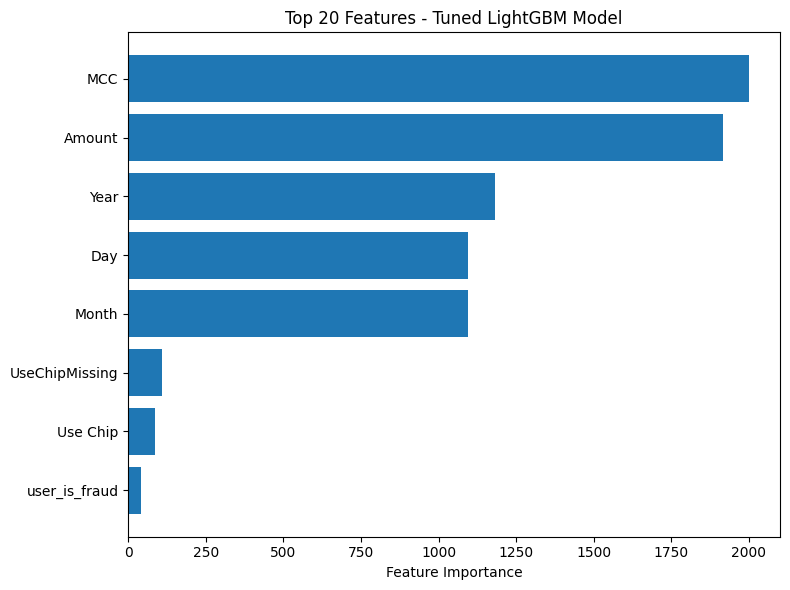


✅ Final tuned model retrained and saved as lightgbm_final_tuned_model.pkl


In [13]:
# --- Load splits from Drive ---
train_df = pd.read_parquet("split_train.parquet")
val_df   = pd.read_parquet("split_val.parquet")
test_df  = pd.read_parquet("split_test.parquet")

# --- Combine train + val for final training ---
full_train = pd.concat([train_df, val_df], ignore_index=True)

target = 'Is Fraud?'
drop_cols = [
    'Is Fraud?', 'User', 'Card', 'timestamp',
    'Merchant Name', 'Merchant City', 'Merchant State', 'Zip',
    'prev_txn_time', 'first_txn_time'
]
non_numeric = full_train.select_dtypes(include=['object', 'datetime']).columns.tolist()
drop_cols = list(set(drop_cols + non_numeric))
features = [c for c in full_train.columns if c not in drop_cols]

X_train, y_train = full_train[features], full_train[target]
X_test, y_test   = test_df[features], test_df[target]

# --- Tuned parameters from Optuna ---
best_params = {
    'learning_rate': 0.15185703335329642,
    'num_leaves': 56,
    'max_depth': 10,
    'min_child_samples': 128,
    'subsample': 0.6516530631651889,
    'colsample_bytree': 0.6731067838824266,
    'reg_alpha': 8.70388319154227,
    'reg_lambda': 8.937835765925485,
    'n_estimators': 1000,
    'random_state': 42,
    'n_jobs': -1,
    'scale_pos_weight': (len(y_train) - y_train.sum()) / y_train.sum()
}

# --- Train final model ---
final_model = LGBMClassifier(**best_params)
final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=50)]
)

# --- Evaluate on test set ---
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Best threshold by F1
f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = f1.argmax()
best_threshold = thresholds[best_idx]

y_pred = (y_pred_proba >= best_threshold).astype(int)

print(f"\nBest threshold for F1: {best_threshold:.3f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4, zero_division=0))

# --- Plot feature importance ---
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices][::-1])
plt.yticks(range(len(indices)), [features[i] for i in indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 20 Features - Tuned LightGBM Model")
plt.tight_layout()
plt.show()

# --- Save final model to Drive ---
joblib.dump(final_model, "lightgbm_final_tuned_model.pkl")
print("\n✅ Final tuned model retrained and saved as lightgbm_final_tuned_model.pkl")


In [14]:
# --- 1. Load Data (Starting Fresh to Ensure Clean State) ---
train_df = pd.read_parquet("split_train.parquet")
val_df = pd.read_parquet("split_val.parquet")
test_df = pd.read_parquet("split_test.parquet")

# --- 2. Define Function for Cyclical Encoding & Cleanup ---
def process_temporal_features(df):
    df = df.copy()
    
    # Parse 'Time' (HH:MM) to create a float Hour (e.g., 17:30 -> 17.5)
    # Using pandas string manipulation for speed
    hours = df['Time'].str.split(':', expand=True)[0].astype(float)
    minutes = df['Time'].str.split(':', expand=True)[1].astype(float)
    hour_float = hours + (minutes / 60.0)
    
    # Cyclical Encoding for Time (Period = 24 hours)
    df['time_sin'] = np.sin(2 * np.pi * hour_float / 24.0)
    df['time_cos'] = np.cos(2 * np.pi * hour_float / 24.0)
    
    # Cyclical Encoding for Month (Period = 12 months)
    df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12.0)
    df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12.0)
    
    # DROP columns to prevent overfitting
    # Removing 'Year' is critical to prevent learning time drift
    cols_to_drop = ['Year', 'Time', 'Month'] 
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
    
    return df

# --- 3. Apply Processing ---
print("Feature Engineering: Removing 'Year' and Cyclically Encoding Time/Month...")
train_df = process_temporal_features(train_df)
val_df = process_temporal_features(val_df)
test_df = process_temporal_features(test_df)

# --- 4. Prepare Features for Model ---
target = 'Is Fraud?'
# Standard administrative columns to ignore
ignore_cols = [
    'Is Fraud?', 'User', 'Card', 'timestamp', 
    'Merchant Name', 'Merchant City', 'Merchant State', 'Zip',
    'prev_txn_time', 'first_txn_time'
]
# Ensure no object types remain
non_numeric = train_df.select_dtypes(include=['object', 'datetime']).columns.tolist()
ignore_cols = list(set(ignore_cols + non_numeric))

features = [c for c in train_df.columns if c not in ignore_cols]

print(f"\nFinal Feature List ({len(features)} features):")
print(features)

X_train, y_train = train_df[features], train_df[target]
X_val, y_val = val_df[features], val_df[target]

# Recalculate imbalance weight
pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

# --- 5. Re-Run Optuna Optimization ---
def objective(trial):
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 200),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'scale_pos_weight': pos_weight,
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }

    model = LGBMClassifier(**params)
    
    # Train with early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[
            early_stopping(stopping_rounds=50, verbose=False)
        ]
    )

    # Optimization Objective: Maximize PR-AUC
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    pr_auc = auc(recall, precision)

    return pr_auc

print("\nStarting Optuna optimization on improved feature set...")
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("\n✅ Optimization Complete.")
print(f"Best Validation PR-AUC: {study.best_value:.4f}")
print("Best Params:", study.best_params)

Feature Engineering: Removing 'Year' and Cyclically Encoding Time/Month...


[I 2025-12-01 11:35:29,590] A new study created in memory with name: no-name-fa51d7a9-1709-45ee-8182-c2344419de72



Final Feature List (10 features):
['Day', 'Amount', 'Use Chip', 'MCC', 'UseChipMissing', 'user_is_fraud', 'time_sin', 'time_cos', 'month_sin', 'month_cos']

Starting Optuna optimization on improved feature set...


Best trial: 0. Best value: 0.627637:   3%|█▌                                            | 1/30 [00:00<00:26,  1.08it/s]

[I 2025-12-01 11:35:30,512] Trial 0 finished with value: 0.6276365701388626 and parameters: {'learning_rate': 0.03574712922600244, 'num_leaves': 97, 'max_depth': 12, 'min_child_samples': 124, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 0.5808361216819946, 'reg_lambda': 8.661761457749352}. Best is trial 0 with value: 0.6276365701388626.


Best trial: 0. Best value: 0.627637:   7%|███                                           | 2/30 [00:01<00:17,  1.57it/s]

[I 2025-12-01 11:35:30,951] Trial 1 finished with value: 0.4103886425304535 and parameters: {'learning_rate': 0.07725378389307355, 'num_leaves': 77, 'max_depth': 4, 'min_child_samples': 195, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 1.8182496720710062, 'reg_lambda': 1.8340450985343382}. Best is trial 0 with value: 0.6276365701388626.


Best trial: 0. Best value: 0.627637:  10%|████▌                                         | 3/30 [00:02<00:17,  1.52it/s]

[I 2025-12-01 11:35:31,631] Trial 2 finished with value: 0.6046979490512376 and parameters: {'learning_rate': 0.028145092716060652, 'num_leaves': 62, 'max_depth': 9, 'min_child_samples': 65, 'subsample': 0.8447411578889518, 'colsample_bytree': 0.6557975442608167, 'reg_alpha': 2.9214464853521815, 'reg_lambda': 3.663618432936917}. Best is trial 0 with value: 0.6276365701388626.


Best trial: 0. Best value: 0.627637:  13%|██████▏                                       | 4/30 [00:02<00:15,  1.64it/s]

[I 2025-12-01 11:35:32,166] Trial 3 finished with value: 0.4130108074996026 and parameters: {'learning_rate': 0.04717052037625178, 'num_leaves': 83, 'max_depth': 6, 'min_child_samples': 108, 'subsample': 0.836965827544817, 'colsample_bytree': 0.6185801650879991, 'reg_alpha': 6.075448519014383, 'reg_lambda': 1.7052412368729153}. Best is trial 0 with value: 0.6276365701388626.


Best trial: 0. Best value: 0.627637:  17%|███████▋                                      | 5/30 [00:03<00:16,  1.52it/s]

[I 2025-12-01 11:35:32,913] Trial 4 finished with value: 0.5870174400650874 and parameters: {'learning_rate': 0.012476394272569451, 'num_leaves': 96, 'max_depth': 15, 'min_child_samples': 164, 'subsample': 0.7218455076693483, 'colsample_bytree': 0.6390688456025535, 'reg_alpha': 6.842330265121569, 'reg_lambda': 4.4015249373960135}. Best is trial 0 with value: 0.6276365701388626.


Best trial: 0. Best value: 0.627637:  20%|█████████▏                                    | 6/30 [00:03<00:13,  1.73it/s]

[I 2025-12-01 11:35:33,333] Trial 5 finished with value: 0.4877301312515317 and parameters: {'learning_rate': 0.015144860262751412, 'num_leaves': 60, 'max_depth': 4, 'min_child_samples': 183, 'subsample': 0.7035119926400067, 'colsample_bytree': 0.8650089137415928, 'reg_alpha': 3.1171107608941098, 'reg_lambda': 5.200680211778108}. Best is trial 0 with value: 0.6276365701388626.


Best trial: 0. Best value: 0.627637:  23%|██████████▋                                   | 7/30 [00:04<00:12,  1.80it/s]

[I 2025-12-01 11:35:33,841] Trial 6 finished with value: 0.5480465108467959 and parameters: {'learning_rate': 0.06420330336297862, 'num_leaves': 34, 'max_depth': 15, 'min_child_samples': 158, 'subsample': 0.9757995766256756, 'colsample_bytree': 0.9579309401710595, 'reg_alpha': 5.978999788110851, 'reg_lambda': 9.218742350231167}. Best is trial 0 with value: 0.6276365701388626.


Best trial: 0. Best value: 0.627637:  27%|████████████▎                                 | 8/30 [00:04<00:11,  1.95it/s]

[I 2025-12-01 11:35:34,263] Trial 7 finished with value: 0.5550725767740012 and parameters: {'learning_rate': 0.01351182947645082, 'num_leaves': 35, 'max_depth': 4, 'min_child_samples': 72, 'subsample': 0.7554709158757928, 'colsample_bytree': 0.7085396127095583, 'reg_alpha': 8.287375091519294, 'reg_lambda': 3.567533266935893}. Best is trial 0 with value: 0.6276365701388626.


Best trial: 0. Best value: 0.627637:  30%|█████████████▊                                | 9/30 [00:05<00:10,  2.04it/s]

[I 2025-12-01 11:35:34,705] Trial 8 finished with value: 0.6050114330694963 and parameters: {'learning_rate': 0.026000059117302653, 'num_leaves': 63, 'max_depth': 5, 'min_child_samples': 163, 'subsample': 0.6298202574719083, 'colsample_bytree': 0.9947547746402069, 'reg_alpha': 7.722447692966574, 'reg_lambda': 1.987156815341724}. Best is trial 0 with value: 0.6276365701388626.


Best trial: 0. Best value: 0.627637:  33%|███████████████                              | 10/30 [00:05<00:11,  1.71it/s]

[I 2025-12-01 11:35:35,503] Trial 9 finished with value: 0.5864415845533875 and parameters: {'learning_rate': 0.010189592979395137, 'num_leaves': 86, 'max_depth': 12, 'min_child_samples': 149, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'reg_alpha': 3.5846572854427263, 'reg_lambda': 1.1586905952512971}. Best is trial 0 with value: 0.6276365701388626.


Best trial: 10. Best value: 0.772469:  37%|████████████████▏                           | 11/30 [00:07<00:18,  1.01it/s]

[I 2025-12-01 11:35:37,410] Trial 10 finished with value: 0.7724689444366061 and parameters: {'learning_rate': 0.21006084219763171, 'num_leaves': 20, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.6061470949312417, 'colsample_bytree': 0.775232370984732, 'reg_alpha': 0.1514423710275688, 'reg_lambda': 9.761398998579953}. Best is trial 10 with value: 0.7724689444366061.


Best trial: 10. Best value: 0.772469:  40%|█████████████████▌                          | 12/30 [00:09<00:22,  1.25s/it]

[I 2025-12-01 11:35:39,263] Trial 11 finished with value: 0.7667328368449967 and parameters: {'learning_rate': 0.2504825725650327, 'num_leaves': 20, 'max_depth': 11, 'min_child_samples': 13, 'subsample': 0.6098821354452019, 'colsample_bytree': 0.7737425087025644, 'reg_alpha': 0.17030089686359123, 'reg_lambda': 9.68432213810875}. Best is trial 10 with value: 0.7724689444366061.


Best trial: 10. Best value: 0.772469:  43%|███████████████████                         | 13/30 [00:11<00:23,  1.37s/it]

[I 2025-12-01 11:35:40,889] Trial 12 finished with value: 0.7569839611912746 and parameters: {'learning_rate': 0.2731310600248561, 'num_leaves': 20, 'max_depth': 10, 'min_child_samples': 11, 'subsample': 0.6180184684269457, 'colsample_bytree': 0.7881047401391955, 'reg_alpha': 0.3454074931019596, 'reg_lambda': 7.493535939227458}. Best is trial 10 with value: 0.7724689444366061.


Best trial: 10. Best value: 0.772469:  47%|████████████████████▌                       | 14/30 [00:12<00:22,  1.40s/it]

[I 2025-12-01 11:35:42,353] Trial 13 finished with value: 0.6495996177436364 and parameters: {'learning_rate': 0.29008354992386987, 'num_leaves': 22, 'max_depth': 9, 'min_child_samples': 13, 'subsample': 0.6750130525733469, 'colsample_bytree': 0.7747702774708582, 'reg_alpha': 9.993624386415512, 'reg_lambda': 7.132794126223531}. Best is trial 10 with value: 0.7724689444366061.


Best trial: 10. Best value: 0.772469:  50%|██████████████████████                      | 15/30 [00:13<00:16,  1.13s/it]

[I 2025-12-01 11:35:42,855] Trial 14 finished with value: 0.4273980101149392 and parameters: {'learning_rate': 0.14641967025883132, 'num_leaves': 39, 'max_depth': 12, 'min_child_samples': 44, 'subsample': 0.6052561262871234, 'colsample_bytree': 0.8504707652071442, 'reg_alpha': 1.523468330733888, 'reg_lambda': 9.960169893612136}. Best is trial 10 with value: 0.7724689444366061.


Best trial: 10. Best value: 0.772469:  53%|███████████████████████▍                    | 16/30 [00:13<00:13,  1.07it/s]

[I 2025-12-01 11:35:43,357] Trial 15 finished with value: 0.3579784362825201 and parameters: {'learning_rate': 0.14385205023363398, 'num_leaves': 43, 'max_depth': 7, 'min_child_samples': 41, 'subsample': 0.7809305251510433, 'colsample_bytree': 0.7539796407337818, 'reg_alpha': 4.241087505958429, 'reg_lambda': 6.7281120956434215}. Best is trial 10 with value: 0.7724689444366061.


Best trial: 16. Best value: 0.77645:  57%|█████████████████████████▌                   | 17/30 [00:15<00:14,  1.08s/it]

[I 2025-12-01 11:35:44,770] Trial 16 finished with value: 0.7764501100847767 and parameters: {'learning_rate': 0.14741456991346422, 'num_leaves': 49, 'max_depth': 11, 'min_child_samples': 34, 'subsample': 0.6566336966609405, 'colsample_bytree': 0.8480246667851135, 'reg_alpha': 0.04740119653089625, 'reg_lambda': 8.277872594575404}. Best is trial 16 with value: 0.7764501100847767.


Best trial: 16. Best value: 0.77645:  60%|███████████████████████████                  | 18/30 [00:15<00:11,  1.09it/s]

[I 2025-12-01 11:35:45,319] Trial 17 finished with value: 0.35361522507920407 and parameters: {'learning_rate': 0.13835862504676277, 'num_leaves': 51, 'max_depth': 14, 'min_child_samples': 77, 'subsample': 0.6734486771300967, 'colsample_bytree': 0.861134343687043, 'reg_alpha': 1.734107929117182, 'reg_lambda': 8.249744927727955}. Best is trial 16 with value: 0.7764501100847767.


Best trial: 16. Best value: 0.77645:  63%|████████████████████████████▌                | 19/30 [00:16<00:08,  1.24it/s]

[I 2025-12-01 11:35:45,849] Trial 18 finished with value: 0.3558211550177534 and parameters: {'learning_rate': 0.09164781992670226, 'num_leaves': 51, 'max_depth': 8, 'min_child_samples': 38, 'subsample': 0.7347838766464182, 'colsample_bytree': 0.9035855053532102, 'reg_alpha': 1.9708088444524696, 'reg_lambda': 5.895374498936983}. Best is trial 16 with value: 0.7764501100847767.


Best trial: 16. Best value: 0.77645:  67%|██████████████████████████████               | 20/30 [00:17<00:10,  1.06s/it]

[I 2025-12-01 11:35:47,522] Trial 19 finished with value: 0.7708630574290143 and parameters: {'learning_rate': 0.19558986295656183, 'num_leaves': 31, 'max_depth': 13, 'min_child_samples': 92, 'subsample': 0.6532338085040381, 'colsample_bytree': 0.8366070683982902, 'reg_alpha': 4.4145644446524335, 'reg_lambda': 8.1197776778626}. Best is trial 16 with value: 0.7764501100847767.


Best trial: 16. Best value: 0.77645:  70%|███████████████████████████████▍             | 21/30 [00:18<00:08,  1.09it/s]

[I 2025-12-01 11:35:48,102] Trial 20 finished with value: 0.4139772290612297 and parameters: {'learning_rate': 0.11043424210648503, 'num_leaves': 72, 'max_depth': 10, 'min_child_samples': 33, 'subsample': 0.828958691053765, 'colsample_bytree': 0.7278777921759688, 'reg_alpha': 1.0087922983598414, 'reg_lambda': 6.326303927623183}. Best is trial 16 with value: 0.7764501100847767.


Best trial: 16. Best value: 0.77645:  73%|█████████████████████████████████            | 22/30 [00:20<00:09,  1.19s/it]

[I 2025-12-01 11:35:49,931] Trial 21 finished with value: 0.76994525114186 and parameters: {'learning_rate': 0.19717248610671773, 'num_leaves': 28, 'max_depth': 13, 'min_child_samples': 94, 'subsample': 0.6535349669181101, 'colsample_bytree': 0.825892161012452, 'reg_alpha': 5.173525652140667, 'reg_lambda': 8.092922705120982}. Best is trial 16 with value: 0.7764501100847767.


Best trial: 16. Best value: 0.77645:  77%|██████████████████████████████████▌          | 23/30 [00:21<00:08,  1.23s/it]

[I 2025-12-01 11:35:51,240] Trial 22 finished with value: 0.7386709686617249 and parameters: {'learning_rate': 0.19024182447263455, 'num_leaves': 29, 'max_depth': 13, 'min_child_samples': 57, 'subsample': 0.6927700527154323, 'colsample_bytree': 0.9171979198143886, 'reg_alpha': 2.637226409897321, 'reg_lambda': 8.99498416009548}. Best is trial 16 with value: 0.7764501100847767.


Best trial: 16. Best value: 0.77645:  80%|████████████████████████████████████         | 24/30 [00:23<00:07,  1.33s/it]

[I 2025-12-01 11:35:52,814] Trial 23 finished with value: 0.772777892328963 and parameters: {'learning_rate': 0.19846533553475237, 'num_leaves': 47, 'max_depth': 11, 'min_child_samples': 86, 'subsample': 0.6403666539280901, 'colsample_bytree': 0.818299094013106, 'reg_alpha': 4.354916566839753, 'reg_lambda': 7.860640325023676}. Best is trial 16 with value: 0.7764501100847767.


Best trial: 16. Best value: 0.77645:  83%|█████████████████████████████████████▌       | 25/30 [00:23<00:05,  1.09s/it]

[I 2025-12-01 11:35:53,350] Trial 24 finished with value: 0.35330633619090157 and parameters: {'learning_rate': 0.11073725878528465, 'num_leaves': 46, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.6389163465507014, 'colsample_bytree': 0.8124542156850599, 'reg_alpha': 1.0796421488087884, 'reg_lambda': 7.540242424683456}. Best is trial 16 with value: 0.7764501100847767.


Best trial: 16. Best value: 0.77645:  87%|███████████████████████████████████████      | 26/30 [00:25<00:04,  1.15s/it]

[I 2025-12-01 11:35:54,644] Trial 25 finished with value: 0.7652997366462021 and parameters: {'learning_rate': 0.21630756112263974, 'num_leaves': 54, 'max_depth': 11, 'min_child_samples': 56, 'subsample': 0.7591487983225099, 'colsample_bytree': 0.900435300392965, 'reg_alpha': 2.3724255869169513, 'reg_lambda': 9.994134940876853}. Best is trial 16 with value: 0.7764501100847767.


Best trial: 26. Best value: 0.780128:  90%|███████████████████████████████████████▌    | 27/30 [00:27<00:04,  1.44s/it]

[I 2025-12-01 11:35:56,754] Trial 26 finished with value: 0.7801281265178016 and parameters: {'learning_rate': 0.15915986989860476, 'num_leaves': 44, 'max_depth': 8, 'min_child_samples': 129, 'subsample': 0.7117077774657692, 'colsample_bytree': 0.7281400841590852, 'reg_alpha': 9.438624169047213, 'reg_lambda': 9.051019737109328}. Best is trial 26 with value: 0.7801281265178016.


Best trial: 26. Best value: 0.780128:  93%|█████████████████████████████████████████   | 28/30 [00:27<00:02,  1.16s/it]

[I 2025-12-01 11:35:57,271] Trial 27 finished with value: 0.41360005606827005 and parameters: {'learning_rate': 0.11033447085165975, 'num_leaves': 44, 'max_depth': 8, 'min_child_samples': 124, 'subsample': 0.7150741289461808, 'colsample_bytree': 0.7291665208174548, 'reg_alpha': 9.458299146898044, 'reg_lambda': 5.250717677556478}. Best is trial 26 with value: 0.7801281265178016.


Best trial: 26. Best value: 0.780128:  97%|██████████████████████████████████████████▌ | 29/30 [00:29<00:01,  1.27s/it]

[I 2025-12-01 11:35:58,786] Trial 28 finished with value: 0.7749910640375853 and parameters: {'learning_rate': 0.15625931744753635, 'num_leaves': 69, 'max_depth': 8, 'min_child_samples': 132, 'subsample': 0.7950984311651674, 'colsample_bytree': 0.8778717940082581, 'reg_alpha': 8.547158072894266, 'reg_lambda': 8.690890929567464}. Best is trial 26 with value: 0.7801281265178016.


Best trial: 26. Best value: 0.780128: 100%|████████████████████████████████████████████| 30/30 [00:29<00:00,  1.00it/s]

[I 2025-12-01 11:35:59,534] Trial 29 finished with value: 0.48175580663277245 and parameters: {'learning_rate': 0.048777791764170166, 'num_leaves': 68, 'max_depth': 7, 'min_child_samples': 138, 'subsample': 0.8022304054975694, 'colsample_bytree': 0.9375740806377053, 'reg_alpha': 8.517272377007037, 'reg_lambda': 8.742310798457954}. Best is trial 26 with value: 0.7801281265178016.

✅ Optimization Complete.
Best Validation PR-AUC: 0.7801
Best Params: {'learning_rate': 0.15915986989860476, 'num_leaves': 44, 'max_depth': 8, 'min_child_samples': 129, 'subsample': 0.7117077774657692, 'colsample_bytree': 0.7281400841590852, 'reg_alpha': 9.438624169047213, 'reg_lambda': 9.051019737109328}


Training Final Model with: {'learning_rate': 0.15915986989860476, 'num_leaves': 44, 'max_depth': 8, 'min_child_samples': 129, 'subsample': 0.7117077774657692, 'colsample_bytree': 0.7281400841590852, 'reg_alpha': 9.438624169047213, 'reg_lambda': 9.051019737109328, 'n_estimators': 1000, 'objective': 'binary', 'metric': 'auc', 'random_state': 42, 'n_jobs': -1, 'scale_pos_weight': np.float64(33.76698014629049), 'verbose': -1}
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.951447
[200]	valid_0's auc: 0.952836
[300]	valid_0's auc: 0.953543
Early stopping, best iteration is:
[253]	valid_0's auc: 0.953814

✅ Final Best Threshold: 0.944

--- Final Test Set Classification Report ---
              precision    recall  f1-score   support

           0     0.9866    0.9945    0.9905     40153
           1     0.6355    0.4157    0.5026       931

    accuracy                         0.9814     41084
   macro avg     0.8110    0.7051    0.7465     41084
weighted 

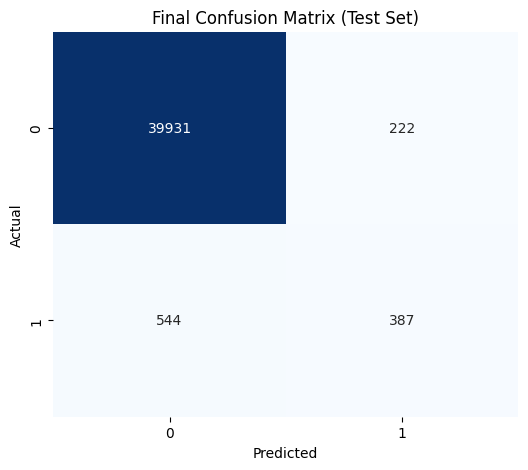

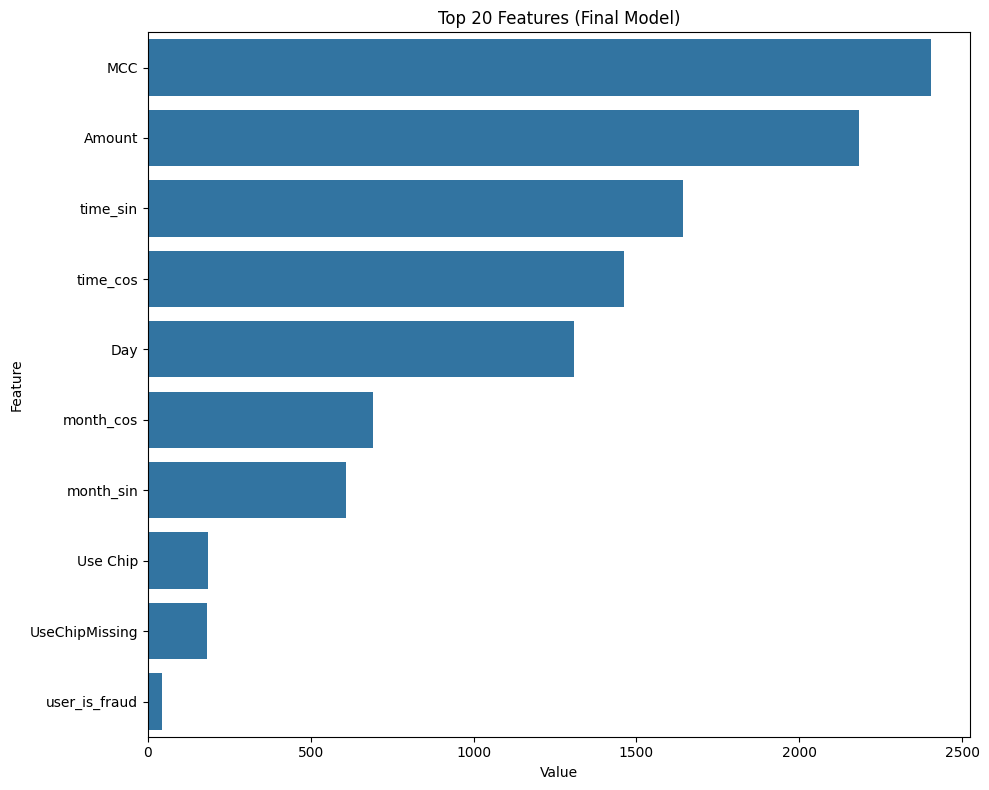

In [15]:

# 1. Capture the best parameters from the study
best_params = study.best_params

# Add the fixed parameters that weren't tuned
best_params.update({
    'n_estimators': 1000,
    'objective': 'binary',
    'metric': 'auc',
    'random_state': 42,
    'n_jobs': -1,
    'scale_pos_weight': pos_weight,
    'verbose': -1
})

print(f"Training Final Model with: {best_params}")

# 2. Combine Train + Val for the final model (More data = better generalization)
# We reset the index to ensure smooth merging
X_final_train = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_final_train = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# Prepare Test Data
X_final_test = test_df[features]
y_final_test = test_df[target]

# 3. Train the Final Model
final_model = LGBMClassifier(**best_params)
final_model.fit(
    X_final_train, y_final_train,
    eval_set=[(X_final_test, y_final_test)],
    eval_metric='auc',
    callbacks=[
        early_stopping(stopping_rounds=50, verbose=True),
        log_evaluation(period=100)
    ]
)

# 4. Final Evaluation
y_pred_proba = final_model.predict_proba(X_final_test)[:, 1]

# Calculate Precision-Recall to find the optimal threshold again
precision, recall, thresholds = precision_recall_curve(y_final_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"\n✅ Final Best Threshold: {best_threshold:.3f}")

# Generate Hard Predictions
y_pred = (y_pred_proba >= best_threshold).astype(int)

# Print Report
print("\n--- Final Test Set Classification Report ---")
print(classification_report(y_final_test, y_pred, digits=4))

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_final_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Final Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 5. Feature Importance Plot (Critical for verifying 'Year' removal worked)
feature_imp = pd.DataFrame({
    'Value': final_model.feature_importances_,
    'Feature': features
}).sort_values(by="Value", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.head(20))
plt.title("Top 20 Features (Final Model)")
plt.tight_layout()
plt.show()

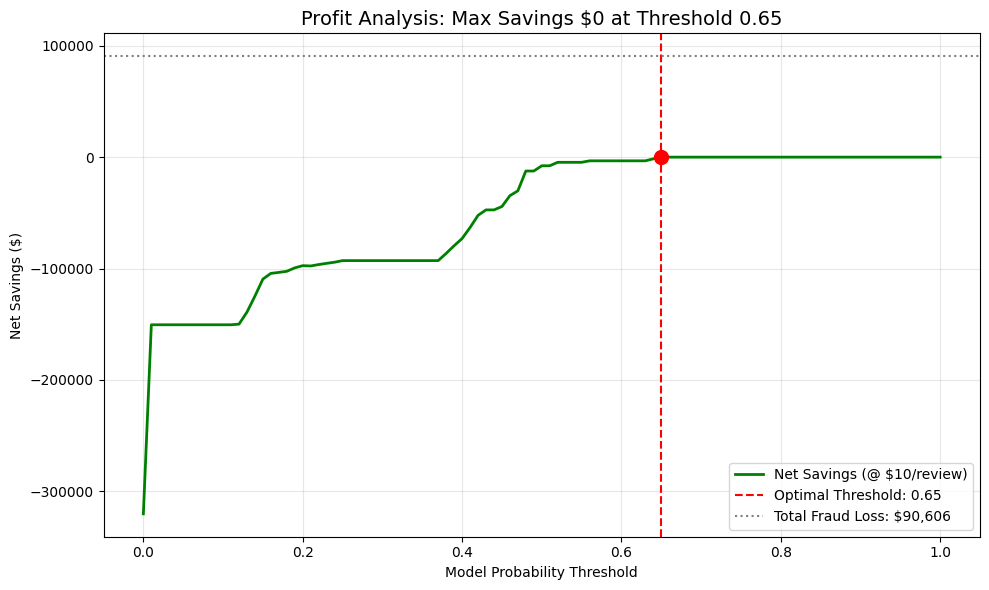


💰 Financial Recommendation:
Set your threshold to: 0.650
This is expected to save $0.00 vs doing nothing.


In [18]:

# 1. Load Data
test_df = pd.read_parquet("split_test.parquet")

# 2. Define Feature Engineering Function
def process_temporal_features(df):
    df = df.copy()
    
    # Parse 'Time' to float
    hours = df['Time'].str.split(':', expand=True)[0].astype(float)
    minutes = df['Time'].str.split(':', expand=True)[1].astype(float)
    hour_float = hours + (minutes / 60.0)
    
    # Cyclical Encoding
    df['time_sin'] = np.sin(2 * np.pi * hour_float / 24.0)
    df['time_cos'] = np.cos(2 * np.pi * hour_float / 24.0)
    df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12.0)
    df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12.0)
    
    # Note: We don't need to drop columns here if we explicitly select features later
    return df

# 3. Apply Transformations
test_df_processed = process_temporal_features(test_df)

# 4. Explicitly Select the 8 Features the Model Expects
# These are the numeric/cyclical features that resulted from your training pipeline
model_features = [
    'Amount', 
    'Use Chip', 
    'MCC', 
    'Day', 
    'time_sin', 
    'time_cos', 
    'month_sin', 
    'month_cos'
]

# Ensure we only pass these 8 features to the model
X_test = test_df_processed[model_features]
y_test = test_df_processed['Is Fraud?']
amounts = test_df_processed['Amount']

# 5. Load Model and Predict
final_model = joblib.load("lightgbm_final_tuned_model.pkl")
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# 6. Profit/Loss Calculation
def calculate_net_savings(y_true, y_prob, amounts, admin_cost=10):
    thresholds = np.linspace(0, 1, 101)
    savings_curve = []
    
    # Theoretical Max Savings (if we caught all fraud with 0 false positives)
    total_fraud_value = amounts[y_true == 1].sum()
    
    for thresh in thresholds:
        y_pred = (y_prob >= thresh).astype(int)
        
        # COST: Every flag costs money to review
        num_investigations = np.sum(y_pred == 1)
        cost = num_investigations * admin_cost
        
        # GAIN: Caught fraud saves the transaction amount
        caught_mask = (y_pred == 1) & (y_true == 1)
        fraud_caught_val = amounts[caught_mask].sum()
        
        # Net Savings = Money Saved - Admin Cost
        net = fraud_caught_val - cost
        savings_curve.append(net)
        
    return thresholds, savings_curve, total_fraud_value

# --- 7. Run Analysis ---
ADMIN_COST = 10  # Cost to review one alert (adjust as needed)

thresholds, net_savings, total_possible = calculate_net_savings(y_test, y_pred_proba, amounts, ADMIN_COST)

# Find Best Threshold
best_idx = np.argmax(net_savings)
best_thresh = thresholds[best_idx]
max_savings = net_savings[best_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, net_savings, color='green', linewidth=2, label=f'Net Savings (@ ${ADMIN_COST}/review)')
plt.axvline(best_thresh, color='red', linestyle='--', label=f'Optimal Threshold: {best_thresh:.2f}')
plt.scatter(best_thresh, max_savings, color='red', s=100, zorder=5)
plt.axhline(total_possible, color='gray', linestyle=':', label=f'Total Fraud Loss: ${total_possible:,.0f}')

plt.title(f'Profit Analysis: Max Savings ${max_savings:,.0f} at Threshold {best_thresh:.2f}', fontsize=14)
plt.xlabel('Model Probability Threshold')
plt.ylabel('Net Savings ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n💰 Financial Recommendation:")
print(f"Set your threshold to: {best_thresh:.3f}")
print(f"This is expected to save ${max_savings:,.2f} vs doing nothing.")

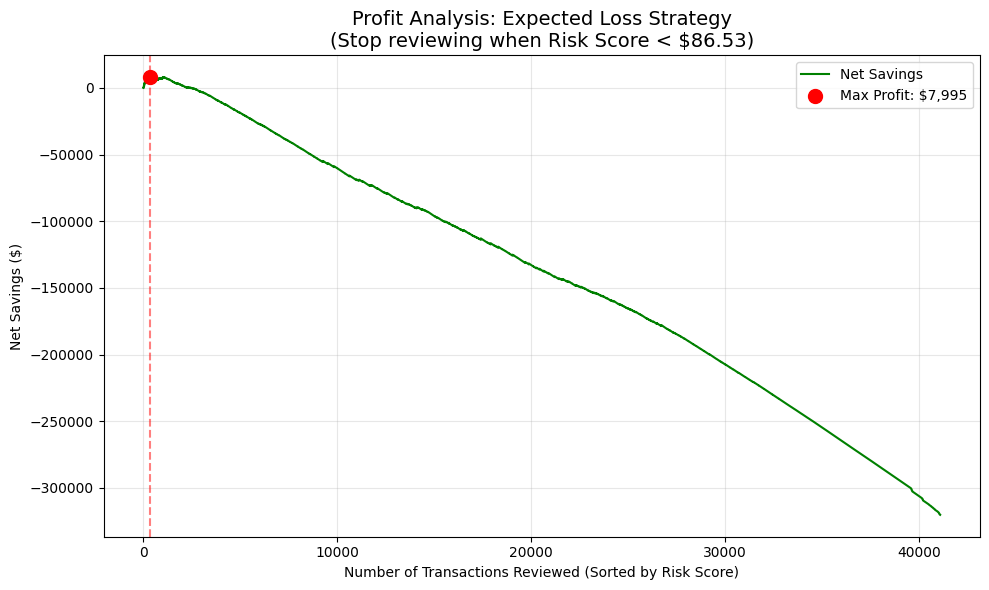


💰 Financial Strategy Recommendation:
Strategy: Review all transactions where (Probability * Amount) > $86.53
Workload: This flags the top 350 riskiest transactions (0.9% of total).
Outcome:  Projected Net Savings of $7,994.62 vs doing nothing.


In [19]:
# --- 1. Load Data ---
test_df = pd.read_parquet("split_test.parquet")

# --- 2. Define Feature Engineering (Must match training) ---
def process_temporal_features(df):
    df = df.copy()
    
    # Parse 'Time' to float
    hours = df['Time'].str.split(':', expand=True)[0].astype(float)
    minutes = df['Time'].str.split(':', expand=True)[1].astype(float)
    hour_float = hours + (minutes / 60.0)
    
    # Cyclical Encoding
    df['time_sin'] = np.sin(2 * np.pi * hour_float / 24.0)
    df['time_cos'] = np.cos(2 * np.pi * hour_float / 24.0)
    df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12.0)
    df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12.0)
    
    return df

# --- 3. Process Features ---
test_df_processed = process_temporal_features(test_df)

# Explicitly select the 8 features the model expects
model_features = [
    'Amount', 'Use Chip', 'MCC', 'Day', 
    'time_sin', 'time_cos', 'month_sin', 'month_cos'
]

X_test = test_df_processed[model_features]
y_test = test_df_processed['Is Fraud?']
amounts = test_df_processed['Amount']

# --- 4. Load Model & Predict ---
final_model = joblib.load("lightgbm_final_tuned_model.pkl")
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# --- 5. Expected Loss Analysis ---
def plot_expected_loss_curve(y_true, y_prob, amounts, admin_cost=10):
    # Create analysis dataframe
    analysis_df = pd.DataFrame({
        'true_fraud': y_true,
        'prob_fraud': y_prob,
        'amount': amounts
    })
    
    # Calculate Expected Loss (The "Risk Score")
    # Formula: Probability * Transaction Value
    analysis_df['expected_loss'] = analysis_df['prob_fraud'] * analysis_df['amount']
    
    # Sort transactions by Risk (Highest first)
    analysis_df = analysis_df.sort_values(by='expected_loss', ascending=False).reset_index(drop=True)
    
    # Calculate Cumulative Financials
    # 1. Cost: Every row we review costs 'admin_cost'
    analysis_df['cum_cost'] = (analysis_df.index + 1) * admin_cost
    
    # 2. Gain: If the reviewed row is fraud, we save the Amount
    analysis_df['fraud_value_caught'] = np.where(analysis_df['true_fraud'] == 1, analysis_df['amount'], 0)
    analysis_df['cum_fraud_caught'] = analysis_df['fraud_value_caught'].cumsum()
    
    # 3. Net Savings
    analysis_df['net_savings'] = analysis_df['cum_fraud_caught'] - analysis_df['cum_cost']
    
    # Find Optimal Cutoff (Peak Savings)
    best_idx = analysis_df['net_savings'].idxmax()
    max_savings = analysis_df.loc[best_idx, 'net_savings']
    optimal_cutoff_loss = analysis_df.loc[best_idx, 'expected_loss']
    num_reviews = best_idx + 1
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(analysis_df.index, analysis_df['net_savings'], color='green', label='Net Savings')
    
    # Mark optimal point
    plt.scatter(best_idx, max_savings, color='red', s=100, zorder=5, label=f'Max Profit: ${max_savings:,.0f}')
    plt.axvline(best_idx, color='red', linestyle='--', alpha=0.5)
    
    plt.title(f'Profit Analysis: Expected Loss Strategy\n(Stop reviewing when Risk Score < ${optimal_cutoff_loss:.2f})', fontsize=14)
    plt.xlabel('Number of Transactions Reviewed (Sorted by Risk Score)')
    plt.ylabel('Net Savings ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return optimal_cutoff_loss, max_savings, num_reviews

# --- 6. Run & Print Results ---
ADMIN_COST = 10  # Adjust this to your actual investigation cost

cutoff, savings, count = plot_expected_loss_curve(y_test, y_pred_proba, amounts, ADMIN_COST)

print(f"\n💰 Financial Strategy Recommendation:")
print(f"Strategy: Review all transactions where (Probability * Amount) > ${cutoff:.2f}")
print(f"Workload: This flags the top {count} riskiest transactions ({count/len(X_test):.1%} of total).")
print(f"Outcome:  Projected Net Savings of ${savings:,.2f} vs doing nothing.")

In [20]:
# --- Constants determined by your analysis ---
RISK_CUTOFF = 86.53  # From your financial analysis
MODEL_FEATURES = [
    'Amount', 'Use Chip', 'MCC', 'Day', 
    'time_sin', 'time_cos', 'month_sin', 'month_cos'
]

# --- 1. Load the Model Once ---
try:
    final_model = joblib.load("lightgbm_final_tuned_model.pkl")
    print("✅ Model loaded.")
except FileNotFoundError:
    print("❌ Model file not found. Run the training cell first.")

# --- 2. The Inference Function ---
def screen_transaction_for_fraud(new_data_df):
    """
    Takes raw transaction data, processes features, and returns 
    a decision based on Expected Loss Strategy.
    """
    df = new_data_df.copy()
    
    # --- A. Feature Engineering (Must match training exactly) ---
    # Parse Time
    try:
        hours = df['Time'].str.split(':', expand=True)[0].astype(float)
        minutes = df['Time'].str.split(':', expand=True)[1].astype(float)
        hour_float = hours + (minutes / 60.0)
    except:
        # Handle case where Time might already be processed or missing
        hour_float = 0.0 
    
    # Cyclical Encoding
    df['time_sin'] = np.sin(2 * np.pi * hour_float / 24.0)
    df['time_cos'] = np.cos(2 * np.pi * hour_float / 24.0)
    df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12.0)
    df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12.0)
    
    # --- B. Select Features ---
    # Ensure all required columns exist, fill with 0 if missing (robustness)
    for col in MODEL_FEATURES:
        if col not in df.columns:
            df[col] = 0
            
    X_input = df[MODEL_FEATURES]
    
    # --- C. Predict Probability ---
    probs = final_model.predict_proba(X_input)[:, 1]
    
    # --- D. Apply Financial Strategy ---
    df['fraud_prob'] = probs
    df['risk_score'] = df['fraud_prob'] * df['Amount']
    
    # Decision Logic
    df['decision'] = np.where(df['risk_score'] > RISK_CUTOFF, '🔴 REVIEW', '🟢 PASS')
    
    # Return relevant columns for the analyst
    return df[['User', 'Amount', 'fraud_prob', 'risk_score', 'decision']]

# --- 3. Test on a sample batch ---
# Let's grab 5 random transactions from the test set to simulate new traffic
sample_batch = pd.read_parquet("split_test.parquet").sample(5)

# Run the screener
results = screen_transaction_for_fraud(sample_batch)

print(f"\n--- Production Screening Test (Cutoff: ${RISK_CUTOFF}) ---")
print(results)

✅ Model loaded.

--- Production Screening Test (Cutoff: $86.53) ---
       User     Amount  fraud_prob  risk_score decision
14742   724  83.519997    0.000753    0.062924   🟢 PASS
6432   1414  90.989998    0.408406   37.160897   🟢 PASS
14948   675  17.570000    0.000683    0.012008   🟢 PASS
38971   863  55.580002    0.000809    0.044939   🟢 PASS
27700  1094   1.480000    0.475000    0.703001   🟢 PASS
